<a href="https://colab.research.google.com/github/NadiaFinzi/diplodatos-mumuki-equipo1/blob/main/Mumuki_E3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Diplomatura en Ciencia de Datos, Aprendizaje Automático y sus Aplicaciones**

**Edición 2021**

---
## Mentoría MUMUKI
## **"Predicción de deserción en una plataforma educativa para aprender a programar".**

### Mentor

- Bulgarelli, Franco Leonardo

### Integrantes

- Finzi, Nadia
- Gherra C., Estefanía Inés
- Primo, Eugenia


# Bibliotecas, funciones e importación de datos

In [1]:
# Librerías y configuraciones generales

# Esenciales
import pandas as pd
import numpy as np
from datetime import datetime, date, time, timedelta
import calendar

# Visualizacion
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.rcParams['axes.facecolor']='w'
plt.rcParams['grid.color'] = 'grey'
plt.rcParams['grid.alpha'] = 0.2 
plt.rcParams['grid.linestyle'] = "-."

%matplotlib inline
import seaborn as sns

# Varios
import warnings
warnings.filterwarnings('ignore')

# Entrenamiento
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE

# Métricas
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, plot_confusion_matrix

In [43]:
# Definición de funciones y procedimientos propios

def graficar_boxplot(dataframe, columna, aclaracion_titulo, label_x, pie_grafico):
  fig = plt.figure(figsize=(8, 6))
  g = sns.boxenplot(data=dataframe, x= columna, color='salmon')
  plt.title('Boxplot de la variable ' + columna + aclaracion_titulo, fontsize=14, weight='bold')
  plt.ylabel("")
  plt.xlabel("\n" + label_x, fontsize=10)
  plt.annotate( pie_grafico, xy=(0.3, -0.25), xycoords='axes fraction', ha='right', va='center', fontsize=12)

def submissions_correctas(df):
  return df[(df["submission_status"] == "passed") | (df["submission_status"] == "passed_with_warnings")]

def submissions_incorrectas(df):
  return df[(df["submission_status"] == "failed") | (df["submission_status"] == "errored")]

def ordenar_y_agrupar(df):
  return df.sort_values(["student_uid", "submission_created_at"]).reset_index(drop=True).groupby(["student_uid", "exercise_new_id"])

def plot_scatter_grid(x, y, exercises):
  row = 3
  col = 2
  i = 1 # inicia el conteo

  plt.figure(figsize = (20,15))
  for exercise in exercises:
    selector = estudiante_por_ejercicio[estudiante_por_ejercicio["exercise_new_id"] == exercise]
    plt.subplot(row, col, i)
    plt.title("Ejercicio " + str(exercise))
    sns.scatterplot(x = x, y = y, hue = 'cond_cant_ejer_resueltos', data = selector, facecolor="dodgerblue", edgecolor="k", palette=["blue", "red"])
    i += 1

  plt.subplots_adjust(wspace = 0.3, hspace = 0.5) 
  plt.show()


In [3]:
# Apertura del dataset desde Google Drive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

def connect_to_drive():
  auth.authenticate_user()
  gauth = GoogleAuth()
  gauth.credentials = GoogleCredentials.get_application_default()
  return GoogleDrive(gauth)

def read_csv_from_drive(drive, id, filename):
  downloaded = drive.CreateFile({'id':id}) 
  downloaded.GetContentFile(filename)  
  return pd.read_csv(filename)

drive = connect_to_drive()  # utilización de la función de apertura de archivos desde drive
df_submissions_0 = read_csv_from_drive(drive, '1oqeKaq164fYieUs6WODv53tF4hl7QY9N', 'df_submissions_python.csv') # el 2° parámetro es el id del archivo (terminación del link en drive)

# 1oqeKaq164fYieUs6WODv53tF4hl7QY9N
# [Fuente: https://colab.research.google.com/drive/1bPwYa_uumNJ7N6NazqSwLr-8dmiCaIj8]


# GENERACIÓN DE DF 

## Limpieza y filtrado

In [4]:
# Corrección de nombres

df_submissions_0["exercise_name"] = np.where(df_submissions_0["exercise_name"] == 'Más booleanos', 'El retorno del booleano' , df_submissions_0["exercise_name"])
df_submissions_0["exercise_name"] = np.where(df_submissions_0["exercise_name"] == 'PIenso que así es más fácil', 'Pienso que así es más fácil', df_submissions_0["exercise_name"])

# Eliminamos "Calefones": 
df_submissions_0 = df_submissions_0[df_submissions_0["exercise_name"] != "Calefones"]

_orden_ejer = {"No tan distintos": 1, "Funciones, declaración": 2, "Funciones, uso": 3, "Probando funciones": 4, "Haciendo cuentas": 5, "Poniendo topes": 6, "¿Es par?": 7, "Libros de la buena memoria": 8, "Booleanos": 9, "Palabras, sólo palabras": 10, "Operando strings": 11, "¡GRITAR!": 12, "¿Y qué tal si...?":13, "¿De qué signo sos?": 14, "El retorno del booleano": 15, "Los premios": 16, "Tipos de datos": 17, "Datos de todo tipo": 18, 
        "Comprando Hardware": 19, "¿Me conviene?": 20, "Triangulos": 21, "Cuadrados": 22, "¿Está afinado?": 23, "¿Está cerca?": 24, "Cartelitos": 25, "Más Cartelitos": 26, "Cartelitos óptimos": 27, "Cara o ceca": 28, "¡Envido!": 29, "¡Quiero retruco!": 30, "¡Quiero vale cuatro!": 31,
        "¿Y el tablero?": 32, "Impresión por pantalla": 33, "Martin Fierro": 34, "¿Y los procedimientos?": 35, "¿Y el program?": 36, "Conversiones": 37, "El círculo de la vida": 38, "Pienso que así es más fácil": 39, "Esto no tiene valor": 40, "Variables globales": 41, "Volviéndonos ricos": 42, "¿Y esto cuánto vale?": 43}

# Mapeo del nombre de los ejercicios con su correspondiente orden dentro de la guía:
df_submissions_0["exercise_new_id"] = df_submissions_0["exercise_name"].map(_orden_ejer)
df_submissions_0["exercise_new_id"] = df_submissions_0["exercise_new_id"].apply(int)

# Eliminamos la columna del viejo id ya que no sera utilizada de aqui en adelante
df_submissions_0 = df_submissions_0.drop("exercise_eid", axis = 1)

# Eliminamos las columnas que no tienen datos
df_submissions_0 = df_submissions_0.drop("feedback", axis = 1)

# Pasamos la fecha a un formato datetime
df_submissions_0["submission_created_at"] = pd.to_datetime(df_submissions_0['submission_created_at'])

# Reemplazamos las listas vacías en test_results por NaN's
df_submissions_0["test_results"] = df_submissions_0.test_results.replace("[]", np.nan)

# Corregimos un outlier (failed que no compilaba y debería ser errored) a partir de result
df_submissions_0["submission_status"] = np.where((df_submissions_0.submission_status == "failed") & (df_submissions_0.result.notna()) , "errored", df_submissions_0.submission_status)

# Se filtran (excluyen por el momento) las pruebas: 
df_submissions = df_submissions_0[df_submissions_0["sid"] != -1]

# Se filtran (excluyen por el momento) status pending y aborted:
df_submissions = df_submissions[~df_submissions["submission_status"].isin(["pending", "aborted"])]

# Se filtran a estudiantes que tuvieron un único envío o son inválidos (por definición o porque su período de trabajo es mayor a un cuatrimestre):
df_submissions = df_submissions[~df_submissions["student_uid"].isin([75, 142, 361, 97, -1])]

# Obtenemos el periodo al que pertenecen l@s estudiantes para poder identificar los cursos: 
    # Creamos una columna que sólo indique el año: 
df_submissions["año"] = df_submissions["submission_created_at"].dt.year

    # Creamos una columna que sólo indique el cuatrimestre: 
df_submissions["cuatrimestre"] = np.where(df_submissions["submission_created_at"].dt.month.isin([ 5,  6,  7, 8]), "2 cuatr.","3 cuatr.")

    # Creamos una columna que sólo indique el día:
dias = {0: "1-Lunes", 1: "2-Martes", 2: "3-Miércoles", 3: "4-Jueves", 4: "5-Viernes", 5: "6-Sábado", 6: "7-Domingo"}
df_submissions["dia"] = df_submissions["submission_created_at"].dt.dayofweek
df_submissions["dia"].replace(dias, inplace =True)


## Cálculo de tiempos

In [5]:
# Tiempo (en segundos) entre cada envío por estudiante:

intervalos_tiempo_por_estudiante = df_submissions.sort_values(by=["student_uid", "submission_created_at"]).groupby('student_uid').submission_created_at.diff().dt.total_seconds().round().reset_index()
intervalos_tiempo_por_estudiante["student_uid"] =  df_submissions.sort_values("student_uid").student_uid.reset_index(drop=True)
intervalos_tiempo_por_estudiante = intervalos_tiempo_por_estudiante.rename(columns = {"submission_created_at": "tiempo_entre_envios"}).drop(columns = "index")
intervalos_tiempo_por_estudiante = intervalos_tiempo_por_estudiante[intervalos_tiempo_por_estudiante.tiempo_entre_envios.between(3, 1200)]

# Tiempo total
tiempo_recorrido_por_estudiante = intervalos_tiempo_por_estudiante.groupby("student_uid").tiempo_entre_envios.sum()

# Tiempo (en segundos) entre cada envío por estudiante y ejercicio:
tiempo_entre_envios_por_ejercicio = df_submissions.sort_values(by=["student_uid", "exercise_new_id", "submission_created_at"]).groupby(by=['student_uid', "exercise_new_id"]).submission_created_at.diff().dt.total_seconds().apply(np.ceil).reset_index()

# Agregamos la información del estudiante y del ejercicio en cuestión
tiempo_entre_envios_por_ejercicio = tiempo_entre_envios_por_ejercicio.fillna(0).rename(columns = {"submission_created_at": "tiempo_entre_intentos"}).drop(columns = ["index"])
tiempo_entre_envios_por_ejercicio[["student_uid", "exercise_new_id", "submission_created_at"]] = df_submissions.sort_values(by=["student_uid", "exercise_new_id", "submission_created_at"]).reset_index()[["student_uid", "exercise_new_id", "submission_created_at"]]

tiempo_entre_envios_por_ejercicio["tiempo_intento_modificado"] = tiempo_entre_envios_por_ejercicio.tiempo_entre_intentos.apply(lambda row: 0 if row > 1200 else row)

# Nuevo tiempo total (en segundos) para cada estudiante en cada ejercicio
tiempo_total_por_ejercicio_2 = tiempo_entre_envios_por_ejercicio.groupby(by=['student_uid', "exercise_new_id"]).agg({"tiempo_intento_modificado": "sum", "submission_created_at": "nunique"}).reset_index()
tiempo_total_por_ejercicio_2.rename(columns = {"tiempo_intento_modificado": "tiempo_total", "submission_created_at": "intentos_totales"}, inplace = True)
tiempo_total_por_ejercicio_2

,student_uid,exercise_new_id,tiempo_total,intentos_totales
0,76,2,0.0,1
1,76,3,0.0,2
2,76,6,0.0,1
3,76,7,30.0,2
4,76,9,915.0,5
...,...,...,...,...
7874,359,43,0.0,1
7875,362,21,87.0,3
7876,363,25,61.0,3
7877,363,26,151.0,4


## Construcción de nuevo df con métricas por estudiante

In [6]:
# Por cada estudiante obtenemos la cantidad de ejercicios con status passed o passed_with_warnings que realizó:
#filtro_status = submissions_correctas(df_submissions)
filtro_status = df_submissions
group_ejer = filtro_status[["student_uid", "exercise_new_id"]]
group_ejer = group_ejer.groupby(["student_uid"]).nunique().rename(columns = {'exercise_new_id': 'ejercicios_resueltos'})

# Creamos la columna de desercion:
# Regla de decision: 
criterio_por_ejercicios_resueltos = group_ejer["ejercicios_resueltos"].quantile(0.25)
#criterio_por_ejercicios_resueltos = 30

df_cond_ejer = group_ejer.copy()
df_cond_ejer["cond_cant_ejer_resueltos"] = np.where(df_cond_ejer["ejercicios_resueltos"] < criterio_por_ejercicios_resueltos, 1, 0)

df_cond_ejer = df_cond_ejer.reset_index() 

# -------

filtro_fallidos = submissions_incorrectas(df_submissions)

# Envíos fallidos por estudiante, por guía/lección, y por ejercicio.

df_fallidos = filtro_fallidos.groupby(['student_uid','exercise_new_id'])['sid'].count().reset_index().rename(columns = {'sid': 'intentos_fallidos_max_ejer'}).sort_values(["student_uid", "intentos_fallidos_max_ejer"], ascending = [True, False])

# Regla de decisión: 
criterio_por_intentos_fallidos = df_fallidos.sort_values(["student_uid", "intentos_fallidos_max_ejer"], ascending = [True, False]).drop_duplicates("student_uid")["intentos_fallidos_max_ejer"].quantile(0.75)

# Creamos la columna de deserción:
df_cond_fallos_ejer = df_fallidos.copy()[["student_uid", "intentos_fallidos_max_ejer"]]
df_cond_fallos_ejer["cond_fallos_ejer"] = np.where(df_fallidos["intentos_fallidos_max_ejer"] > criterio_por_intentos_fallidos, 1, 0)

df_cond_fallos_ejer = df_cond_fallos_ejer.sort_values('intentos_fallidos_max_ejer', ascending = False).drop_duplicates('student_uid')

# -------

# Cantidad de ejercicios intentados (en cualquier estado) por persona

group_ejer_int = df_submissions[["student_uid", "exercise_new_id"]]
group_ejer_int = group_ejer_int.groupby(["student_uid"]).nunique().rename(columns = {'exercise_new_id': 'ejercicios_totales'})
group_ejer_int = group_ejer_int.reset_index()

# -------

intervalos_tiempo_por_estudiante = df_submissions.sort_values(by=["student_uid", "submission_created_at"]).groupby('student_uid').submission_created_at.diff().dt.total_seconds().round().reset_index()
intervalos_tiempo_por_estudiante["student_uid"] = df_submissions.sort_values("student_uid").student_uid.reset_index(drop=True)
intervalos_tiempo_por_estudiante = intervalos_tiempo_por_estudiante.rename(columns = {"submission_created_at": "tiempo_total_invertido"}).drop(columns = "index")

# Nos quedamos con los intervalos de tiempo que se hayan realizado entre 3 segundos y 20 minutos
intervalos_tiempo_por_estudiante = intervalos_tiempo_por_estudiante[intervalos_tiempo_por_estudiante.tiempo_total_invertido.between(3, 1200)]
df_cond_tiempo_ejer = intervalos_tiempo_por_estudiante.groupby('student_uid', as_index=False).sum()



# DF con las condiciones obtenidas a partir de las metricas de deserción

df_condiciones = df_cond_ejer.merge(df_cond_tiempo_ejer, on = "student_uid", how = "outer")
df_condiciones = df_condiciones.merge(df_cond_fallos_ejer, on = "student_uid", how = "outer")
df_condiciones = df_condiciones.merge(group_ejer_int, on = "student_uid", how = "outer")
df_condiciones = df_condiciones.fillna(0)
df_condiciones['ejercicios_fallidos'] = df_condiciones.ejercicios_totales - df_condiciones.ejercicios_resueltos

# -------
df_condiciones['tiempo_prom_por_ej_correcto'] = df_condiciones.tiempo_total_invertido / df_condiciones.ejercicios_resueltos
df_condiciones['tiempo_prom_por_ejercicio'] = df_condiciones.tiempo_total_invertido / df_condiciones.ejercicios_totales

# Regla de decisión: 
criterio_por_tiempo_por_ejercicio = df_condiciones["tiempo_prom_por_ejercicio"].quantile(0.75)

df_condiciones["cond_tiempo_prom_ejer"] = np.where(df_condiciones["tiempo_prom_por_ejercicio"] > criterio_por_tiempo_por_ejercicio, 1, 0)

# -------

intentos_totales = df_submissions.groupby('student_uid', as_index=False).sid.count().rename(columns={"sid":"intentos_totales"}) # envios totales por persona
intentos_incorrectos = submissions_incorrectas(df_submissions).groupby('student_uid', as_index=False).sid.count().rename(columns={"sid":"intentos_incorrectos"}) # envios fallidos por persona
intentos_correctos = submissions_correctas(df_submissions).groupby('student_uid', as_index=False).sid.count().rename(columns={"sid":"intentos_correctos"}) # envios correctos por persona

# Agregamos las columnas con cantidad de intentos totales y distinguidos por estado
df_condiciones = df_condiciones.merge(intentos_totales, on = "student_uid", how = "outer")
df_condiciones = df_condiciones.merge(intentos_incorrectos, on = "student_uid", how = "outer")
df_condiciones = df_condiciones.merge(intentos_correctos, on = "student_uid", how = "outer")

df_condiciones = df_condiciones[["student_uid", "ejercicios_totales", "ejercicios_fallidos","ejercicios_resueltos", "cond_cant_ejer_resueltos", "intentos_totales","intentos_incorrectos","intentos_correctos", "intentos_fallidos_max_ejer","cond_fallos_ejer","tiempo_total_invertido","tiempo_prom_por_ej_correcto","tiempo_prom_por_ejercicio","cond_tiempo_prom_ejer"]]
df_condiciones

,student_uid,ejercicios_totales,ejercicios_fallidos,ejercicios_resueltos,cond_cant_ejer_resueltos,intentos_totales,intentos_incorrectos,intentos_correctos,intentos_fallidos_max_ejer,cond_fallos_ejer,tiempo_total_invertido,tiempo_prom_por_ej_correcto,tiempo_prom_por_ejercicio,cond_tiempo_prom_ejer
0,76,31,0,31,0,62,30.0,32.0,7.0,0.0,8514.0,274.645161,274.645161,0
1,77,34,0,34,0,127,89.0,38.0,30.0,0.0,11682.0,343.588235,343.588235,0
2,78,6,0,6,1,66,62.0,4.0,37.0,1.0,7043.0,1173.833333,1173.833333,1
3,79,19,0,19,1,65,47.0,18.0,10.0,0.0,4464.0,234.947368,234.947368,0
4,80,14,0,14,1,103,92.0,11.0,26.0,0.0,7093.0,506.642857,506.642857,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
276,355,8,0,8,1,15,11.0,4.0,4.0,0.0,2020.0,252.500000,252.500000,0
277,358,1,0,1,1,6,5.0,1.0,5.0,0.0,96.0,96.000000,96.000000,0
278,359,13,0,13,1,31,19.0,12.0,6.0,0.0,4322.0,332.461538,332.461538,0
279,362,1,0,1,1,3,3.0,NaN,3.0,0.0,87.0,87.000000,87.000000,0


## Construcción de nuevo df con métricas por estudiante y ejercicio

In [7]:
ultimo_estado = ordenar_y_agrupar(df_submissions).tail(1)[["student_uid", "exercise_new_id", "submission_status"]]
ultimo_estado = ultimo_estado.rename(columns={"submission_status": "ultimo_estado"})

#Tablas por estudiante y ejercicio con cantidad de intentos en cada estado:
correctos = ordenar_y_agrupar(submissions_correctas(df_submissions)).agg({"sid": "count", "submission_created_at": "min"})
correctos = correctos.rename(columns = {"sid": "intentos_correctos", "submission_created_at": "fecha_primer_correcto"})

incorrectos = ordenar_y_agrupar(submissions_incorrectas(df_submissions)).agg({"sid": "count", "submission_created_at": "max"})
incorrectos = incorrectos.rename(columns = {"sid": "intentos_incorrectos", "submission_created_at": "fecha_ultimo_incorrecto"})

estudiante_por_ejercicio = pd.concat([correctos, incorrectos], axis = 1).reset_index()

#-----

estudiante_por_ejercicio = pd.merge(estudiante_por_ejercicio, ultimo_estado)
estudiante_por_ejercicio = pd.merge(estudiante_por_ejercicio, tiempo_total_por_ejercicio_2)

#-----

# Reordenamos las columnas
estudiante_por_ejercicio = estudiante_por_ejercicio[["student_uid", "exercise_new_id", "ultimo_estado", "intentos_totales", "intentos_correctos", "intentos_incorrectos", "tiempo_total", "fecha_primer_correcto", "fecha_ultimo_incorrecto"]]
estudiante_por_ejercicio

#-----

# Agregamos columnas de condiciones para tener más info y distinguir deserción
estudiante_por_ejercicio = pd.merge(estudiante_por_ejercicio, df_condiciones[["student_uid", "ejercicios_totales","ejercicios_resueltos", "cond_cant_ejer_resueltos", "intentos_fallidos_max_ejer"]], on = "student_uid", how = "left")
estudiante_por_ejercicio.fillna(0, inplace = True)

estudiante_por_ejercicio.head()


,student_uid,exercise_new_id,ultimo_estado,intentos_totales,intentos_correctos,intentos_incorrectos,tiempo_total,fecha_primer_correcto,fecha_ultimo_incorrecto,ejercicios_totales,ejercicios_resueltos,cond_cant_ejer_resueltos,intentos_fallidos_max_ejer
0,76,2,passed,1,1.0,0.0,0.0,2019-08-30 13:17:17.700000,0,31,31,0,7.0
1,76,3,passed,2,1.0,1.0,0.0,2019-09-10 20:00:32.156000,2019-08-30 13:40:26.023000,31,31,0,7.0
2,76,6,passed,1,1.0,0.0,0.0,2019-09-23 12:24:41.746000,0,31,31,0,7.0
3,76,7,passed,2,1.0,1.0,30.0,2019-09-10 20:09:15.049000,2019-09-10 20:08:45.875000,31,31,0,7.0
4,76,9,passed,5,1.0,4.0,915.0,2019-09-23 13:05:45.340000,2019-09-23 13:04:41.529000,31,31,0,7.0


# ANALISIS

Para la generación del modelo baseline de predicción.

1- Búsqueda de ejercicios difíciles

In [15]:
# Para ver la cantidad de estudiantes que llegaron como máximo, a cada ejercicio.

ejercicios_alcanzados = estudiante_por_ejercicio.groupby("student_uid").exercise_new_id.max().value_counts().reset_index()
ejercicios_alcanzados.rename(columns= {"exercise_new_id": "estudiantes", "index": "exercise_new_id"}, inplace = True)

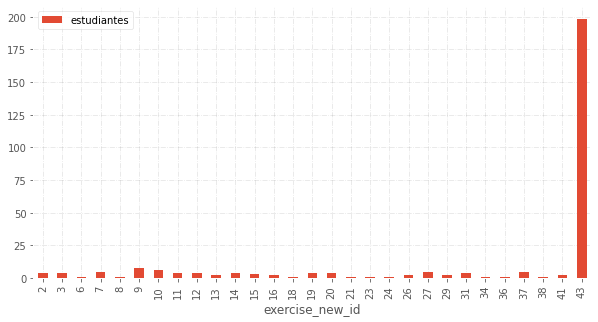

In [17]:
ejercicios_alcanzados.sort_values("exercise_new_id").plot.bar(x = "exercise_new_id", y = "estudiantes", figsize = (10, 5) )

En el gráfico anterior vemos cuánta gente llegó a cada ejercicio como máximo y no pudo continuar resolviendo satisfactoriamente los siguientes. Dejando de lado el 43 (final del recorrido), los picos indicarían aquellos ejercicios "difíciles" que dejaron a más gente en el camino.

Recordar que no están todos listados ya que fueron descartados los ejercicios de consola.

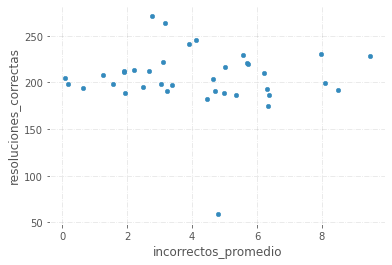

In [18]:
# Gráfico de dispersión de los ejercicios, considerando para cada ejercicio el par ordenado:
#  cantidad de intentos incorrectos promedio por ejercicio 
#  y cantidad de resoluciones correctas (ya sean passed o passed with warning) por ejercicio

info_ejercicios = pd.merge(estudiante_por_ejercicio.groupby("exercise_new_id").agg({"intentos_incorrectos":'sum', "student_uid": "nunique"}).reset_index().rename(columns={"student_uid": "estudiantes"}), estudiante_por_ejercicio[(estudiante_por_ejercicio.ultimo_estado == "passed") | (estudiante_por_ejercicio.ultimo_estado == "passed_with_warnings")].groupby('exercise_new_id').student_uid.nunique().reset_index().rename(columns={"student_uid": "resoluciones_correctas"}))
info_ejercicios["incorrectos_promedio"] = info_ejercicios.intentos_incorrectos / info_ejercicios.estudiantes
info_ejercicios.plot.scatter(y = "resoluciones_correctas", x = "incorrectos_promedio")

In [19]:
# Para identificar los cuatro ejercicio de la derecha del gráfico

info_ejercicios[info_ejercicios.incorrectos_promedio > 7]

,exercise_new_id,intentos_incorrectos,estudiantes,resoluciones_correctas,incorrectos_promedio
7,10,2350.0,248,228,9.475806
8,11,1911.0,240,230,7.962500
16,20,1845.0,217,192,8.502304
22,26,1742.0,215,199,8.102326


In [20]:
info_ejercicios["gente_que_no_paso"] = info_ejercicios.estudiantes - info_ejercicios.resoluciones_correctas

In [21]:
# De acá podemos sacar los ejercicios con más deserción

info_ejercicios.sort_values("gente_que_no_paso", ascending = False)

,exercise_new_id,intentos_incorrectos,estudiantes,resoluciones_correctas,incorrectos_promedio,gente_que_no_paso
16,20,1845.0,217,192,8.502304,25
7,10,2350.0,248,228,9.475806,20
23,27,1309.0,205,186,6.385366,19
6,9,1019.0,260,241,3.919231,19
22,26,1742.0,215,199,8.102326,16
26,30,879.0,197,182,4.461929,15
31,37,1291.0,205,193,6.297561,12
28,34,953.0,202,191,4.717822,11
24,28,654.0,202,191,3.237624,11
34,41,1052.0,197,186,5.340102,11


In [22]:
# ejercicios con menos de 100 resoluciones correctas

info_ejercicios[info_ejercicios.resoluciones_correctas < 100]

,exercise_new_id,intentos_incorrectos,estudiantes,resoluciones_correctas,incorrectos_promedio,gente_que_no_paso
4,7,308.0,64,59,4.8125,5


2- Búsqueda de relaciones mediante gráficos por ejercicios, entre las variables relevantes y la variable objetivo (desertor vs no desertor).

En las siguientes celdas hacemos distintos gráficos para ver el comportamiento de  las variables tiempo total invertido por estudiante y ejercicio, e intentos fallidos por estudiante y ejercicio, clasificando los estudiantes en desertores o no según la métrica "cantidad de ejercicio resuletos". 
Estos gráficos se harán para los ejercicios seleccionados como "difíciles".

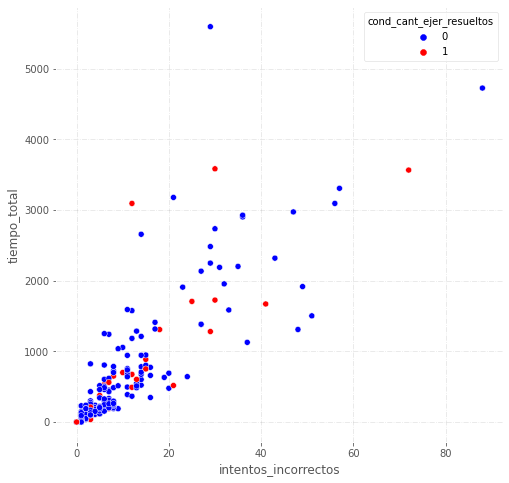

In [26]:
# Primer gráfico -- >  ejercicio 10   
# aquí usamos intentos incorrectos totales por ejercicio y persona  
plt.figure(figsize=(8,8))
sns.scatterplot(x='intentos_incorrectos', y='tiempo_total', hue = 'cond_cant_ejer_resueltos', data = estudiante_por_ejercicio[estudiante_por_ejercicio.exercise_new_id == 10], palette=["blue", "red"])

In [29]:
# Traemos la información del outlier que se visualiza en el primer gráfico
estudiante_por_ejercicio[(estudiante_por_ejercicio.intentos_incorrectos > 80) & (estudiante_por_ejercicio.exercise_new_id == 10)]

,student_uid,exercise_new_id,ultimo_estado,intentos_totales,intentos_correctos,intentos_incorrectos,tiempo_total,fecha_primer_correcto,fecha_ultimo_incorrecto,ejercicios_totales,ejercicios_resueltos,cond_cant_ejer_resueltos,intentos_fallidos_max_ejer
1334,148,10,passed,89,1.0,88.0,4724.0,2020-05-08 02:25:14.453000,2020-05-08 02:19:29.334000,36,36,0,88.0


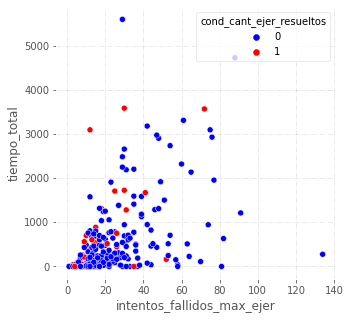

In [28]:
# gráfico para el ejercicio 10, 
#  pero con la variable intentos fallidos máximos por ejercicio en el eje x.

plt.figure(figsize=(5,5))
sns.scatterplot(x='intentos_fallidos_max_ejer', y='tiempo_total', hue = 'cond_cant_ejer_resueltos', data = estudiante_por_ejercicio[estudiante_por_ejercicio.exercise_new_id == 10], palette=["blue", "red"])

In [30]:
estudiante_por_ejercicio.head()

,student_uid,exercise_new_id,ultimo_estado,intentos_totales,intentos_correctos,intentos_incorrectos,tiempo_total,fecha_primer_correcto,fecha_ultimo_incorrecto,ejercicios_totales,ejercicios_resueltos,cond_cant_ejer_resueltos,intentos_fallidos_max_ejer
0,76,2,passed,1,1.0,0.0,0.0,2019-08-30 13:17:17.700000,0,31,31,0,7.0
1,76,3,passed,2,1.0,1.0,0.0,2019-09-10 20:00:32.156000,2019-08-30 13:40:26.023000,31,31,0,7.0
2,76,6,passed,1,1.0,0.0,0.0,2019-09-23 12:24:41.746000,0,31,31,0,7.0
3,76,7,passed,2,1.0,1.0,30.0,2019-09-10 20:09:15.049000,2019-09-10 20:08:45.875000,31,31,0,7.0
4,76,9,passed,5,1.0,4.0,915.0,2019-09-23 13:05:45.340000,2019-09-23 13:04:41.529000,31,31,0,7.0


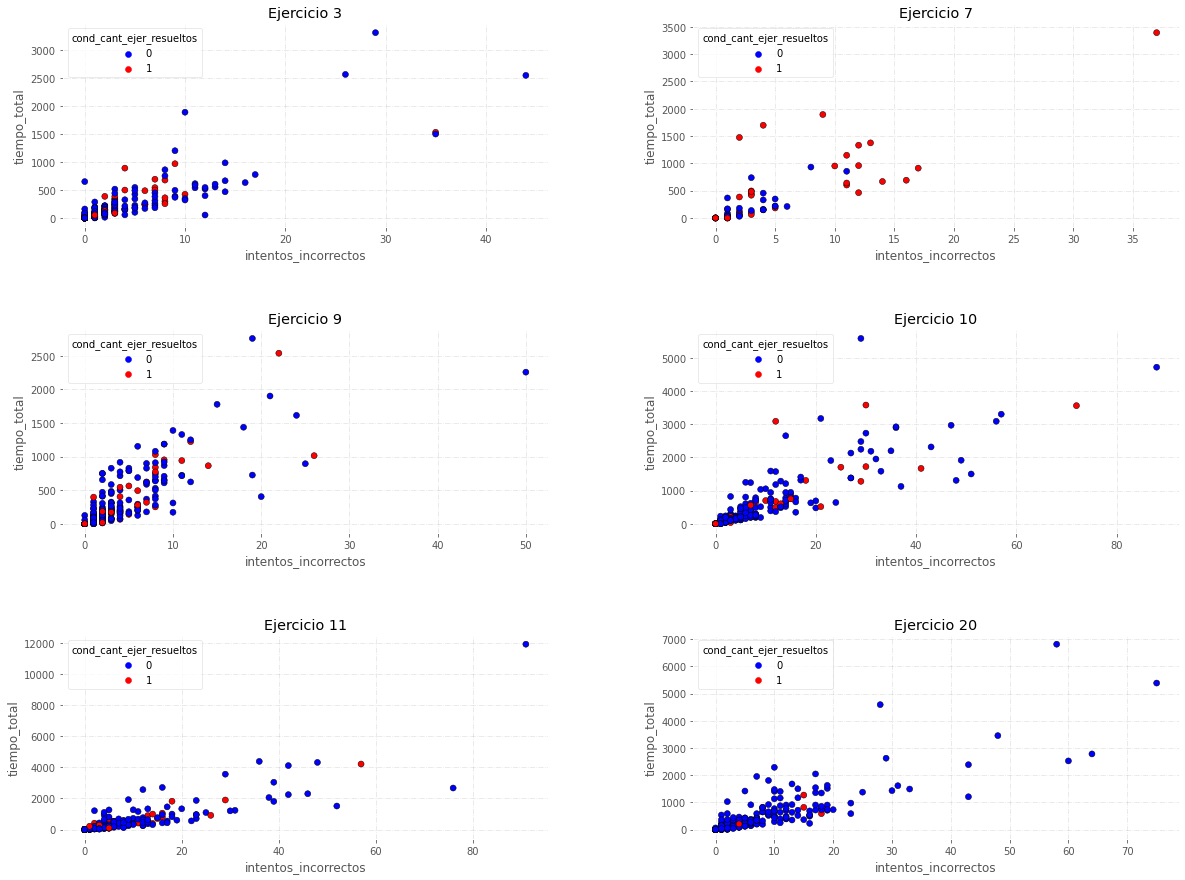

In [45]:
# Hacemos todos los gráficos para los ejercicios considerados "difíciles".

plot_scatter_grid('intentos_incorrectos', 'tiempo_total', [3, 7, 9, 10, 11, 20])

Notar: 
* El ejercicio 7 tiene menos puntos que los demás. Esto se relaciona con el cambio de nombre del ejercicio visto en la entrega 1, motivo por el cual lo pudieron hacer menos personas. Decidimos quitarlo del análisis.



# ENTREGA 3

Se muestran los gráficos finales para los ejercicios seleccionados como "difíciles":

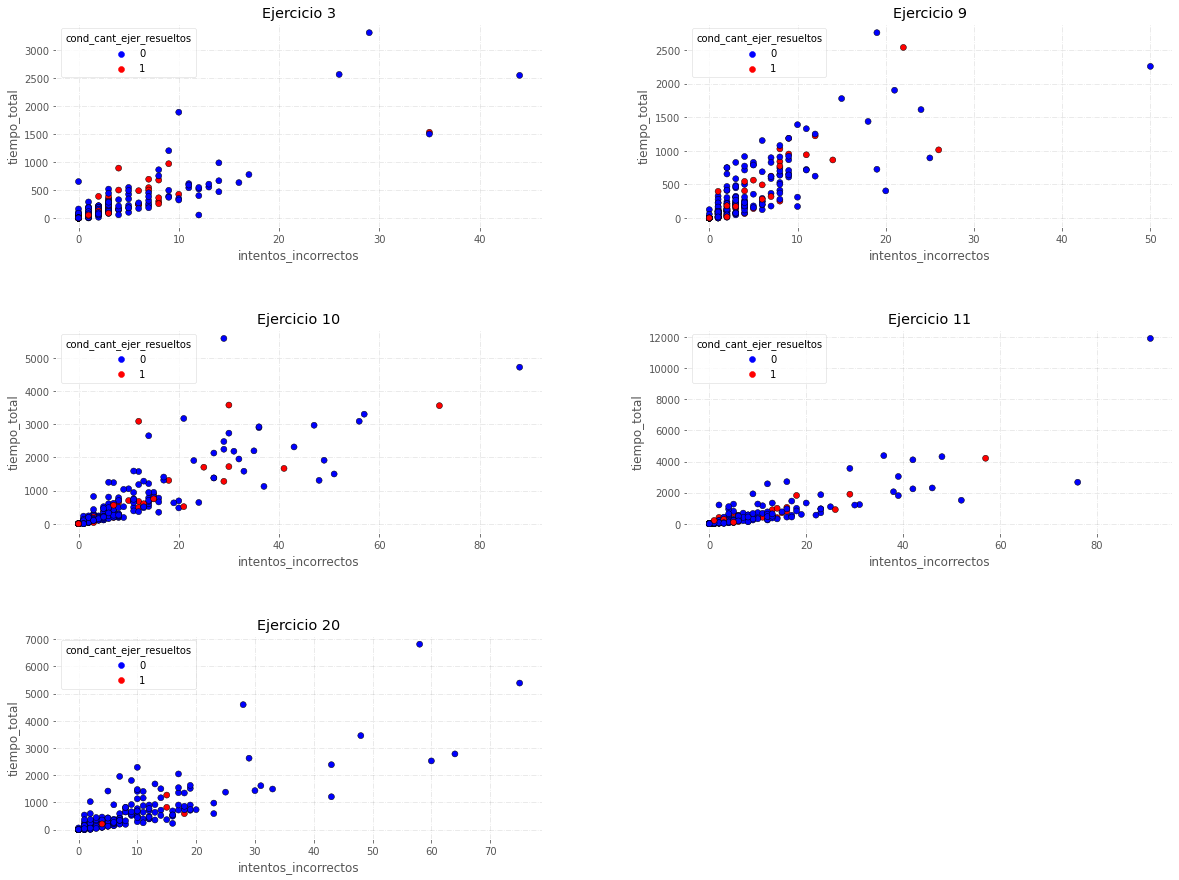

In [47]:
plot_scatter_grid('intentos_incorrectos', 'tiempo_total', [3, 9, 10, 11, 20])

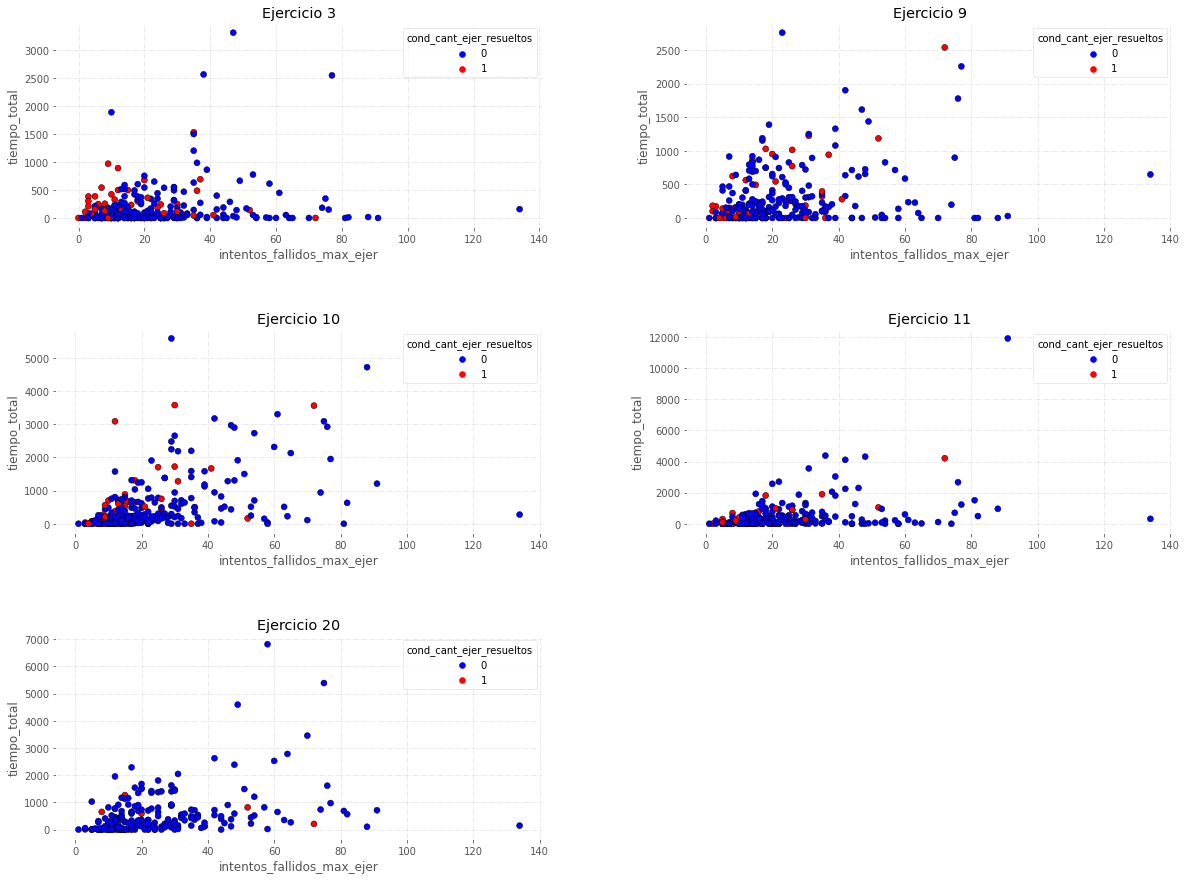

In [48]:
plot_scatter_grid('intentos_fallidos_max_ejer', 'tiempo_total', [3, 9, 10, 11, 20])

In [ ]:
data = estudiante_por_ejercicio[estudiante_por_ejercicio.exercise_new_id.isin([1,3,9,10,11,20])][["student_uid", "cond_cant_ejer_resueltos", "exercise_new_id", "intentos_incorrectos", "tiempo_total"]]
data["exercise_new_id"] = data["exercise_new_id"].astype(str)
data_por_estudiante = pd.pivot_table(data, index= ["student_uid", "cond_cant_ejer_resueltos"], columns = ["exercise_new_id"], fill_value=0)

data_por_estudiante.columns = ['_'.join(col).strip() for col in data_por_estudiante.columns.values]

data_por_estudiante = data_por_estudiante.reset_index()

In [ ]:
data_por_estudiante.head()

,student_uid,cond_cant_ejer_resueltos,intentos_incorrectos_1,intentos_incorrectos_10,intentos_incorrectos_11,intentos_incorrectos_20,intentos_incorrectos_3,intentos_incorrectos_9,tiempo_total_1,tiempo_total_10,tiempo_total_11,tiempo_total_20,tiempo_total_3,tiempo_total_9
0,76,0,0,1,1,0,1,4,0,20,60,0,0,915
1,77,0,0,14,1,4,0,1,0,522,10,332,0,24
2,78,1,0,0,0,0,7,11,0,0,0,0,694,941
3,79,1,0,10,6,3,1,2,0,700,140,142,67,70
4,80,1,0,7,13,0,0,26,0,445,898,0,0,1014


* En general no vemos "gráficamente" una "división" clara de los puntos azules (no desertores = 0) y rojos (desertores = 1), como sí veíamos en la Entrega 2, al trabajar con los totales para todos los ejercicios juntos.

* Procederemos a generar el modelo logísitco de predicción de deserción, utilizando como features la combinación entre las variables tiempo invertido e intentos incorrectos, con cada uno de los ejercicios seleccionados como difíciles. Este modelo servirá como "baseline" de comparación frente a otros modelos o alternativas futuras, posiblemente mejores.

#Generación de función logística para predecir deserción.

In [ ]:
X = data_por_estudiante.drop(columns = ["cond_cant_ejer_resueltos"])
y = data_por_estudiante.cond_cant_ejer_resueltos

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [ ]:
lr = LogisticRegression(random_state=0).fit(X_train, y_train)
y_train_pred_lr = lr.predict(X_train)
y_test_pred_lr = lr.predict(X_test)

In [ ]:
print(classification_report(y_train, y_train_pred_lr))

              precision    recall  f1-score   support

           0       0.81      0.92      0.86       146
           1       0.56      0.32      0.41        47

    accuracy                           0.77       193
   macro avg       0.68      0.62      0.63       193
weighted avg       0.75      0.77      0.75       193



In [ ]:
print(classification_report(y_test, y_test_pred_lr))

              precision    recall  f1-score   support

           0       0.86      0.97      0.91        65
           1       0.82      0.47      0.60        19

    accuracy                           0.86        84
   macro avg       0.84      0.72      0.76        84
weighted avg       0.85      0.86      0.84        84



En los resultados observamos un buen accuracy tanto en train como en test.

Sin embargo, obtuvimos un recall bajo en ambos conjuntos para la clase 1, lo que indicaría que el modelo está prediciendo o clasificando sólo el 47% de los alumnos desertores ante la presencia de "nuevos datos" (ver en resultados de test).
Esto podría ser un problema relacionado con el desbalanceo de clases, donde la 1 (desertores) está subrepresentada:

In [ ]:
data_por_estudiante.cond_cant_ejer_resueltos.value_counts()

0    211
1     66
Name: cond_cant_ejer_resueltos, dtype: int64

Considerando esta situación, decidimos utilizar la técnica SMOTE (Synthetic Minority Over-sampling Technique) para abordar el desbalanceo.

El método SMOTE se basa en el sobremuestreo generando datos sintéticos, a partir de características comunes entre las muestras de la clase minoritaria. 

Concretamente, el algoritmo se centrará sobre la clase minoritaria, en donde cada muestra de este subconjunto calculará sus K-vecinos más próximos. El número de vecinos K a tener en cuenta es un parámetro previamente dado al algoritmo (por defecto = 5), el cual define el número de vecinos a seleccionar.

Los k vecinos pertenecen también a esa clase minoritaria, y son aquellas muestras cuya distancia euclidiana a la muestra principal seleccionada es la menor. Posteriormente, se selecciona uno de los K vecinos de forma aleatoria y se replica generando muestras sintéticas entre la muestra principal seleccionadas y sus vecinos. Este proceso se repetirá hasta alcanzar un equilibrio entre ambas clases.

Esta generación sintética mejora lo ofrecido por otras técnicas básicas, aumentando el conjunto de datos. Sin embargo, también posee ciertas desventajas como la sobregeneración y el valor de la varianza obtenido que provoca solapamiento entre clases.

En una próxima entrega se abordarán otros algoritmos para mejorar esta situación.

In [ ]:
X = data_por_estudiante.drop(columns = ["cond_cant_ejer_resueltos"])
y = data_por_estudiante[["cond_cant_ejer_resueltos"]]

oversample = SMOTE(random_state=0)
X_smo, y_smo = oversample.fit_resample(X, y)

X_train_smo, X_test_smo, y_train_smo, y_test_smo = train_test_split(X_smo, y_smo, test_size=0.3, random_state=0)

In [ ]:
lr_smo = LogisticRegression(random_state=0).fit(X_train_smo, y_train_smo)
y_train_pred_lr_smo = lr_smo.predict(X_train_smo)
y_test_pred_lr_smo = lr_smo.predict(X_test_smo)

In [ ]:
print(classification_report(y_train_smo, y_train_pred_lr_smo))

              precision    recall  f1-score   support

           0       0.87      0.76      0.81       144
           1       0.80      0.89      0.84       151

    accuracy                           0.83       295
   macro avg       0.83      0.83      0.83       295
weighted avg       0.83      0.83      0.83       295



In [ ]:
print(classification_report(y_test_smo, y_test_pred_lr_smo))

              precision    recall  f1-score   support

           0       0.78      0.75      0.76        67
           1       0.73      0.77      0.75        60

    accuracy                           0.76       127
   macro avg       0.76      0.76      0.76       127
weighted avg       0.76      0.76      0.76       127



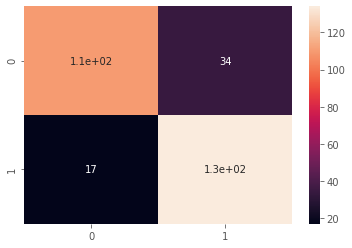

In [ ]:
sns.heatmap(confusion_matrix(y_train_smo, y_train_pred_lr_smo), annot= True)

<Figure size 432x288 with 0 Axes>

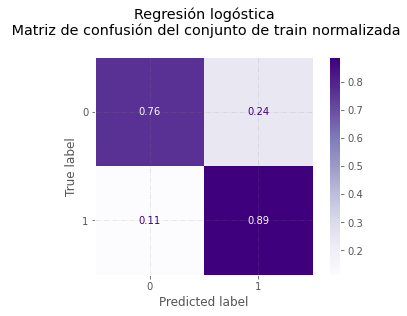

In [ ]:
plt.figure()
plot_confusion_matrix(estimator=lr_smo, X=X_train_smo, y_true=y_train_smo,
                      normalize='true', cmap='Purples').ax_.set_title('Regresión logóstica\n Matriz de confusión del conjunto de train normalizada\n');